In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
from sklearn.metrics import (
    make_scorer, accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from linearboost import LinearBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import shap


import sys
import os

sys.path.append(os.path.abspath('../src'))

from model import *

In [2]:
df = pd.read_parquet('../data/processed/enriched_dataset.parquet')

## Data preparation for the model

We could choose to train the model on the features relevant according to the EDA, I chose to also consider the other variables that seemed relevant from a business point of view to see if the models could capture a pattern.

We remove the distance feature as it is highly correlated to the price.

In [3]:
# Features selection considering the EDA 
core_features = [
    'unit_seat_price_eur',
    # 'segment_distance_km', # highly correlated to price
    'to_cluster_popularity',
    'from_cluster_popularity',
    'is_main_segment',
    'price_x_popularity', 
    'seats_x_distance' # Even if correlated with distance and price, seats_x_distance could capture a multiplicative effect
]

bonus_features = [
    'driver_account_age_days',
    'driver_trip_count',
    'departure_hour',
    'departure_weekday',
    'hours_before_departure',
    'is_auto_accept_mode',
    'fixed_signup_country_grouped',
    'is_weekend',
    'is_holiday',
]

extended_features = core_features + bonus_features

In [4]:
# boolean variables encoding 0/1
bool_features = [
    'is_main_segment',
    'is_auto_accept_mode',
    'is_holiday', 
    'success', 
]

for var in bool_features:
    df[var] = df[var].astype(int)

# transformation departure_hour
df['hour_sin'] = np.sin(2 * np.pi * df['departure_hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['departure_hour'] / 24)

# one-hot encoding
one_hot_features = [
    'departure_weekday',
    'fixed_signup_country_grouped', 
]
df = pd.get_dummies(df, columns=one_hot_features, drop_first=True)
df.head()

,driver_id,trip_id,segment_id,segment_datetime,published_date,signup_date,fixed_signup_country,is_main_segment,unit_seat_price_eur,seat_offered_count,...,hour_sin,hour_cos,departure_weekday_1,departure_weekday_2,departure_weekday_3,departure_weekday_4,departure_weekday_5,departure_weekday_6,fixed_signup_country_grouped_foreign,fixed_signup_country_grouped_missing
0,1396837,5582378,62200180,2015-06-10 17:00:00,2012-05-02,2010-09-08,FR,1,34.32,4,...,-0.965926,-0.258819,False,True,False,False,False,False,False,False
1,3640947,5660204,62979529,2015-05-10 02:40:00,2012-05-10,2012-05-02,FR,1,11.88,3,...,0.500000,0.866025,False,False,False,False,False,True,False,False
2,3834551,5915312,65467862,2015-06-04 01:50:00,2012-06-04,2012-06-04,FR,1,22.44,3,...,0.258819,0.965926,False,False,True,False,False,False,False,False
3,3680123,5994384,66264106,2015-06-12 02:30:00,2012-06-12,2012-05-10,FR,0,7.92,2,...,0.500000,0.866025,False,False,False,True,False,False,False,False
4,3680123,5994384,66264107,2015-06-12 02:30:00,2012-06-12,2012-05-10,FR,0,15.84,2,...,0.500000,0.866025,False,False,False,True,False,False,False,False


Transform the time into two continuous variables, to capture the proximity between 11 p.m. and 0 a.m. without the explosion of variables that would have occurred with one-hot.

In [5]:
bonus_features += ['hour_sin', 'hour_cos', 'departure_weekday_1', 'departure_weekday_2', 
                   'departure_weekday_3', 'departure_weekday_4', 'departure_weekday_5', 
                   'departure_weekday_6', 'fixed_signup_country_grouped_foreign', 
                   'fixed_signup_country_grouped_missing',
                   ] 

bonus_features.remove('departure_hour')
bonus_features.remove('departure_weekday')
bonus_features.remove('fixed_signup_country_grouped')

In [6]:
X = df[core_features + bonus_features].copy()
# X = df[core_features].copy()
y = df['success'] 

# Spliting the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# Standardisation
scaler = StandardScaler()

# Numerical columns to scale
num_cols = [
    'unit_seat_price_eur',
    'segment_distance_km',
    'to_cluster_popularity',
    'from_cluster_popularity',
    'price_x_popularity', 
    'seats_x_distance',
    'driver_account_age_days', # attention
    'driver_trip_count', # attention
    'departure_hour',
    'hours_before_departure', 
]

core_num_cols = list(set(core_features + bonus_features) & set(num_cols))
# core_num_cols = list(set(core_features) & set(num_cols))

X_train[core_num_cols] = scaler.fit_transform(X_train[core_num_cols])
X_test[core_num_cols] = scaler.transform(X_test[core_num_cols])


## Model training (benchmark)

These models were selected to provide a diverse range of classification algorithms, each with different underlying assumptions and strengths, particularly suited to imbalanced binary classification. Logistic Regression offers a strong linear baseline, while Decision Tree and Random Forest bring interpretability and the ability to model non-linear relationships. LightGBM, XGBoost, and CatBoost are powerful gradient boosting frameworks known for their performance on structured data; each is configured to handle class imbalance via class_weight or scale_pos_weight. LinearBoost is included as a lightweight boosting alternative. Finally, Naive Bayes serves as a probabilistic baseline, useful for comparison due to its simplicity and speed.

In [7]:
# Calculation of class weights for the models (XGBoost and CatBoost)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
class_weights = [len(y_train) / (2 * (y_train == 0).sum()), len(y_train) / (2 * (y_train == 1).sum())]

In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42),
    "LightGBM": LGBMClassifier(objective='binary', class_weight='balanced', n_estimators=100, max_depth=7, random_state=42, verbosity=-1),
    "XGBoost": XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, n_estimators=100, max_depth=7, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(iterations=100, depth=7, class_weights=class_weights, verbose=0, random_state=42),
    "LinearBoost": LinearBoostClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB()
}

Training: Logistic Regression
Training: Decision Tree
Training: Random Forest
Training: LightGBM
Training: XGBoost
Training: CatBoost
Training: LinearBoost
Training: Naive Bayes

Cross Validation results:


,test_accuracy,test_recall,test_precision,test_f1,test_auc_pr,fit_time
XGBoost,0.735636,0.787219,0.307644,0.442397,NaN,19.295394
CatBoost,0.728715,0.790897,0.302077,0.437176,NaN,51.947263
LightGBM,0.720354,0.783621,0.293888,0.427460,NaN,22.256816
Random Forest,0.679288,0.790735,0.264564,0.396472,NaN,724.468219
Logistic Regression,0.703729,0.677453,0.262693,0.378583,NaN,13.905844
Decision Tree,0.623484,0.825243,0.237449,0.368741,NaN,26.337778
Naive Bayes,0.830718,0.309855,0.347973,0.327801,NaN,3.521631
LinearBoost,0.744659,0.408355,0.235587,0.298723,NaN,15.426233


Test results:


,model,test_accuracy,test_precision,test_recall,test_f1,test_auc_pr,inference_time
4,XGBoost,0.736009,0.308083,0.787924,0.442965,0.471452,0.189908
5,CatBoost,0.729446,0.302590,0.790098,0.437592,0.462215,0.039103
3,LightGBM,0.720571,0.294041,0.783463,0.427600,0.446438,0.517648
2,Random Forest,0.679310,0.264556,0.790636,0.396454,0.409117,3.018472
1,Decision Tree,0.627610,0.238790,0.820625,0.369934,0.345011,0.034754
0,Logistic Regression,0.703848,0.263010,0.678680,0.379105,0.321014,0.034885
7,Naive Bayes,0.830424,0.346957,0.309373,0.327089,0.285768,0.131479
6,LinearBoost,0.741564,0.235112,0.417149,0.300729,0.225646,0.384177


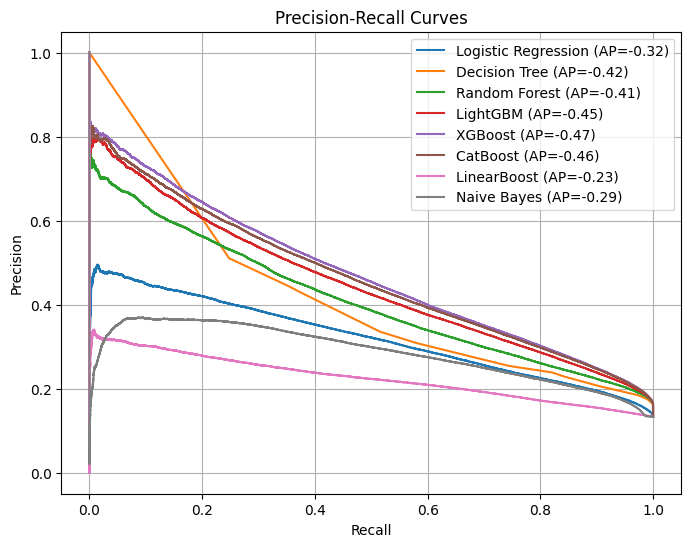

In [9]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'auc_pr': make_scorer(average_precision_score, needs_proba=True)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_df, test_df, pr_curves = evaluate_and_plot(models, X_train, y_train, X_test, y_test, scoring, cv)

print("\nCross Validation results:")
display(cv_df.sort_values(by="test_f1", ascending=False))
print("Test results:")
display(test_df.sort_values(by="test_auc_pr", ascending=False))

plot_pr_curves(pr_curves, y_test, X_test)

## XGBoost optimization

XGBoost was selected for further exploration because it consistently outperformed the other models in our initial benchmarking, especially in terms of precision-recall trade-off on the minority class. While no model achieved perfect results, XGBoost showed the best balance between recall and precision, making it a good performer in a challenging imbalanced setting. It also offered acceptable inference time, unlike more computationally heavy models like CatBoost. Additionally, its native support for handling class imbalance (scale_pos_weight) and compatibility with explainability tools like SHAP made it a practical and interpretable choice for deeper optimization.

In [9]:
X_train = joblib.load('../data/processed/X_train.pkl')
y_train = joblib.load('../data/processed/y_train.pkl')
X_test = joblib.load('../data/processed/X_test.pkl')
y_test = joblib.load('../data/processed/y_test.pkl')

In [10]:
# Training of XGBoost with random search

xgb = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), eval_metric="logloss")
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1],
    "colsample_bytree": [0.7, 0.8, 1],
}
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist,
                                   n_iter=50, scoring="average_precision",
                                   cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Saving the best model
joblib.dump(best_model, '../results/best_model_xgb.pkl')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


['../results/best_model_xgb.pkl']

In [11]:
best_params = random_search.best_params_
print("Best parameters found:", best_params)
joblib.dump(best_params, '../results/best_params_xgb.pkl')

Best parameters found: {'subsample': 1, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


['../results/best_params_xgb.pkl']

In [10]:
# Optimal threshold according to PR curve
start = time.time()
probas = best_model.predict_proba(X_test)[:, 1]
inference_time = time.time() - start
precision, recall, thresholds = precision_recall_curve(y_test, probas)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]
joblib.dump(best_threshold, '../results/optimal_threshold.pkl')
print(f"Optimal threshold for F1-score: {best_threshold:.3f}")

Optimal threshold for F1-score: 0.656


This block of code determines the optimal classification threshold for the XGBoost model by analyzing the Precision-Recall (PR) curve. After predicting the probabilities for the test set, it computes precision and recall values for different thresholds. Then, it calculates the F1-score at each threshold to balance precision and recall. The threshold that maximizes the F1-score is selected as the optimal one, helping to make better binary classification decisions, especially in the context of imbalanced data where the default threshold of 0.5 may not be ideal.

              precision    recall  f1-score   support

           0       0.93      0.88      0.90    580590
           1       0.42      0.58      0.49     89232

    accuracy                           0.84    669822
   macro avg       0.68      0.73      0.70    669822
weighted avg       0.86      0.84      0.85    669822

test_precision 0.4213528998873672
test_recall 0.578548054509593
test_f1 0.48759409503480455
inference time 0.9510860443115234


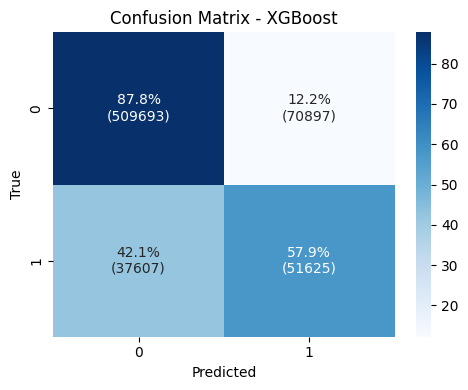

In [11]:
best_model = joblib.load('../results/best_model_xgb.pkl')
final_evaluation(probas, y_test, best_threshold, inference_time)

100%|===================| 669769/669822 [242:40<00:01]         

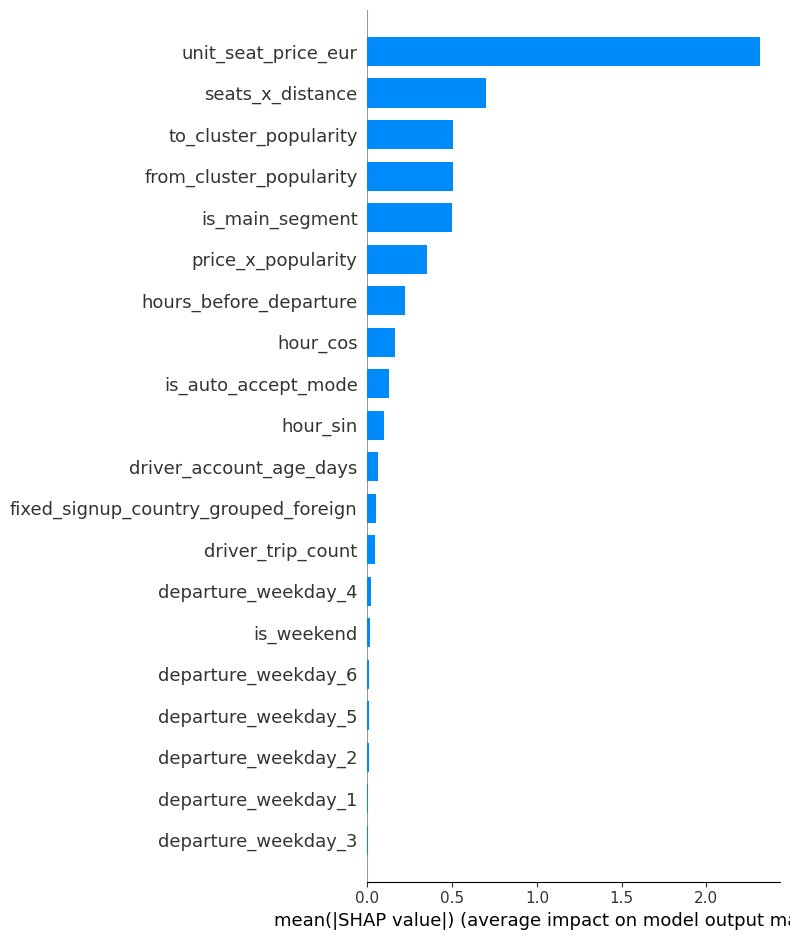

In [14]:
# Feature importance

bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train_shap = X_train.copy()
X_test_shap = X_test.copy()
X_train_shap[bool_cols] = X_train[bool_cols].astype(int)
X_test_shap[bool_cols] = X_test[bool_cols].astype(int)

explainer = shap.Explainer(best_model, X_train_shap)
shap_values = explainer(X_test_shap)
shap.summary_plot(shap_values, X_test_shap, plot_type="bar")

In [15]:
joblib.dump(shap_values, '../results/shap_values.pkl')

['../results/shap_values.pkl']

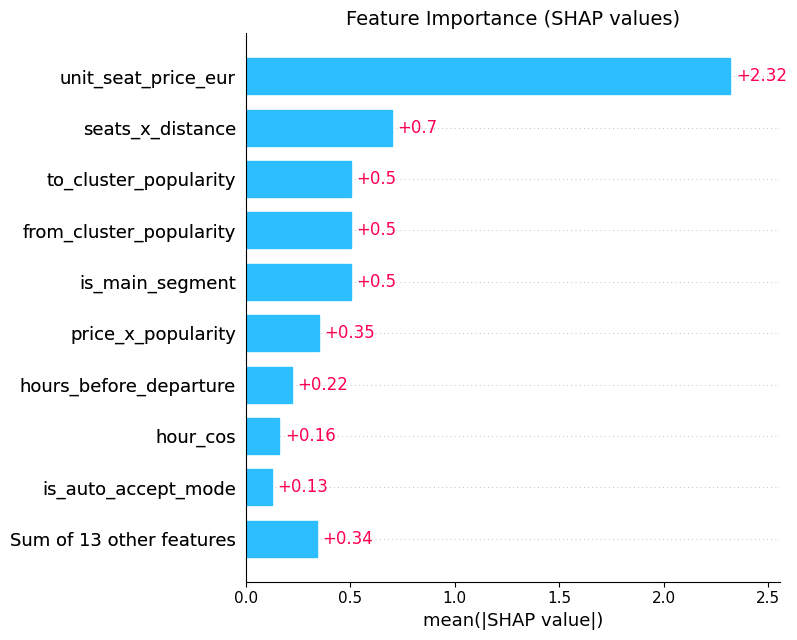

In [18]:
shap.plots.bar(
    shap_values,
    max_display=10,
    show=False  # Permet de personnaliser ensuite avec Matplotlib
)

plt.title("Feature Importance (SHAP values)", fontsize=14)
plt.gca().patch.set_facecolor('white')
for bar in plt.gca().patches:
    bar.set_color("#2CBEFF")  # Bleu personnalisé

plt.tight_layout()
plt.savefig("../results/shap_importance_barplot.png", dpi=300)  # Pour insertion dans tes slides
plt.show()

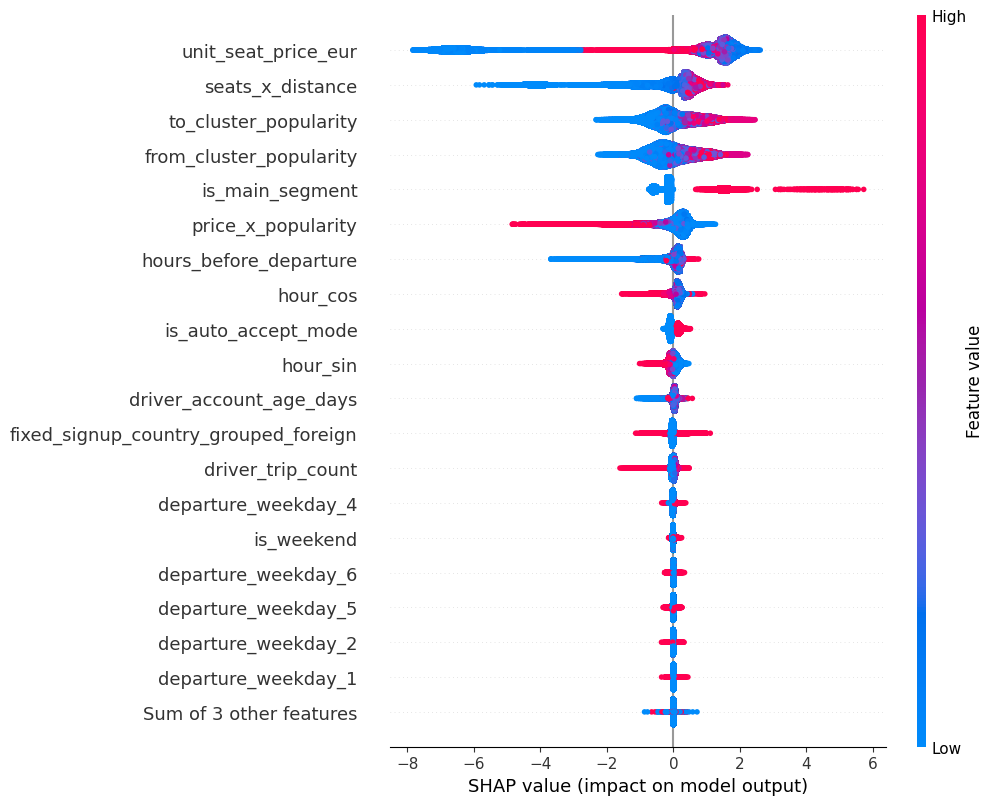

In [19]:
# beeswarm plot : blue = negative impact, red = positiv impact
shap.plots.beeswarm(shap_values, max_display=20)  # top 20 features

plt.show()

The number of variables we are going to consier for the final model will depend on the performance addition of each supplementary variable (we aim between 10-15 features)

In [20]:
# absolute mean of shap values by feature
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(shap_values.values).mean(axis=0)
})

shap_importance = shap_importance.sort_values(by='importance', ascending=False)

In [21]:
# Loop on the number of features to understand the addition of each one and where to cut-off
for n in range(5, 21):
    top_features = shap_importance[:n]["feature"].tolist()
    X_train_sub = X_train[top_features]
    X_test_sub = X_test[top_features]
    
    best_model.fit(X_train_sub, y_train)
    y_pred = best_model.predict(X_test_sub)
    print(f"{n} features – F1: {f1_score(y_test, y_pred):.4f}")

5 features – F1: 0.4311
6 features – F1: 0.4360
7 features – F1: 0.4469
8 features – F1: 0.4466
9 features – F1: 0.4498
10 features – F1: 0.4509
11 features – F1: 0.4518
12 features – F1: 0.4521
13 features – F1: 0.4530
14 features – F1: 0.4525
15 features – F1: 0.4533
16 features – F1: 0.4540
17 features – F1: 0.4532
18 features – F1: 0.4537
19 features – F1: 0.4541
20 features – F1: 0.4533


In [22]:
n = 13
top_features = shap_importance['feature'].head(n).tolist()
joblib.dump(top_features, '../results/final_features.pkl')
top_features

['unit_seat_price_eur',
 'seats_x_distance',
 'to_cluster_popularity',
 'from_cluster_popularity',
 'is_main_segment',
 'price_x_popularity',
 'hours_before_departure',
 'hour_cos',
 'is_auto_accept_mode',
 'hour_sin',
 'driver_account_age_days',
 'fixed_signup_country_grouped_foreign',
 'driver_trip_count']

## Final model

              precision    recall  f1-score   support

           0       0.93      0.88      0.90    580590
           1       0.42      0.58      0.49     89232

    accuracy                           0.84    669822
   macro avg       0.67      0.73      0.69    669822
weighted avg       0.86      0.84      0.85    669822

test_precision 0.4187823655179702
test_recall 0.57730410615026
test_f1 0.4854292997111774
inference time 0.8988120555877686


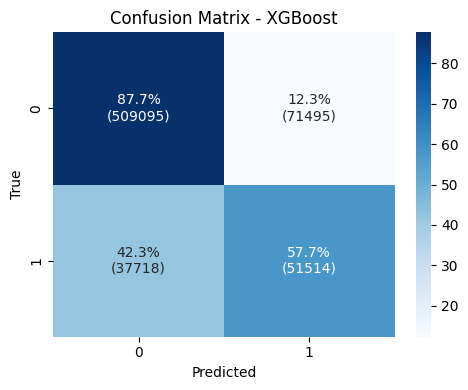

In [12]:
train_and_test_model()

Final inference time (0.8988120555877686) is better than before feature selection (0.951086044311523) and the performance remains the same.